<a href="https://colab.research.google.com/github/shintaroudlotulhanafia/TugasAkhirMultipleStocks/blob/main/TugasAkhirShinta2022_MultipleStocks(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [1]:
## install finrl library
!pip install git+https://github.com/shintaroudlotulhanafia/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/shintaroudlotulhanafia/FinRL.git to /tmp/pip-req-build-3idogg96
  Running command git clone -q https://github.com/shintaroudlotulhanafia/FinRL.git /tmp/pip-req-build-3idogg96
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-4216mv_m/pyfolio_f3d2be11d5d5410f9db40cd9cf546566
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-4216mv_m/pyfolio_f3d2be11d5d5410f9db40cd9cf546566
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-4216mv_m/elegantrl_c24324ec26b34649811cabdeeac6288e
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-4216mv_m/elegantrl_c24324ec26b34649811cabdeeac6288e
     |████████████████████████████████| 2.3 MB 9.4 MB/s 
     |████████████████████████████████| 234 kB 77.2 MB/s 
     |██████████████████████


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [4]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE

'2014-01-06'

In [5]:
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [6]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2015-12-31'
TRADE_START_DATE = '2016-01-01'
TRADE_END_DATE = '2018-12-31'

In [7]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.LQ45_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
print(config_tickers.LQ45_TICKER)

['ACES.JK', 'ADRO.JK', 'AKRA.JK', 'ANTM.JK', 'ASII.JK', 'BBCA.JK', 'BBNI.JK', 'BBRI.JK', 'BBTN.JK', 'BMRI.JK', 'BRPT.JK', 'BSDE.JK', 'CPIN.JK', 'ERAA.JK', 'EXCL.JK', 'GGRM.JK', 'HMSP.JK', 'ICBP.JK', 'INCO.JK', 'INDF.JK', 'INKP.JK', 'INTP.JK', 'ITMG.JK', 'JPFA.JK', 'JSMR.JK', 'KLBF.JK', 'MDKA.JK', 'MEDC.JK', 'MIKA.JK', 'MNCN.JK', 'PGAS.JK', 'PTBA.JK', 'PTPP.JK', 'PWON.JK', 'SMGR.JK', 'SMRA.JK', 'TBIG.JK', 'TINS.JK', 'TKIM.JK', 'TLKM.JK', 'TOWR.JK', 'TPIA.JK', 'UNTR.JK', 'UNVR.JK', 'WIKA.JK']


In [9]:
df.shape

(106264, 8)

In [10]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-05,74.000000,74.000000,74.000000,59.970501,10000000,ACES.JK,0
1,2009-01-05,520.000000,520.000000,485.000000,276.809113,3,ADRO.JK,0
2,2009-01-05,138.000000,144.000000,130.000000,83.811485,2990000,AKRA.JK,0
3,2009-01-05,957.573608,1049.971069,949.173828,820.693359,158999024,ANTM.JK,0
4,2009-01-05,1100.000000,1255.000000,1080.000000,819.928284,80705000,ASII.JK,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [11]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2513, 8)
Successfully added vix
Successfully added turbulence index


In [12]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [13]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-05,ADRO.JK,520.000000,520.000000,485.000000,276.809113,3.0,0.0,0.0,281.675721,266.619232,0.0,66.666667,100.0,276.809113,276.809113,39.080002,0.0
1,2009-01-05,AKRA.JK,138.000000,144.000000,130.000000,83.811485,2990000.0,0.0,0.0,281.675721,266.619232,0.0,66.666667,100.0,83.811485,83.811485,39.080002,0.0
2,2009-01-05,ANTM.JK,957.573608,1049.971069,949.173828,820.693359,158999024.0,0.0,0.0,281.675721,266.619232,0.0,66.666667,100.0,820.693359,820.693359,39.080002,0.0
3,2009-01-05,ASII.JK,1100.000000,1255.000000,1080.000000,819.928284,80705000.0,0.0,0.0,281.675721,266.619232,0.0,66.666667,100.0,819.928284,819.928284,39.080002,0.0
4,2009-01-05,BBCA.JK,700.000000,700.000000,650.000000,562.346008,76682500.0,0.0,0.0,281.675721,266.619232,0.0,66.666667,100.0,562.346008,562.346008,39.080002,0.0
5,2009-01-05,BBNI.JK,1772.763916,1772.763916,1772.763916,1187.034424,0.0,0.0,0.0,281.675721,266.619232,0.0,66.666667,100.0,1187.034424,1187.034424,39.080002,0.0
6,2009-01-05,BBRI.JK,485.000000,500.000000,472.500000,341.407959,163680000.0,0.0,0.0,281.675721,266.619232,0.0,66.666667,100.0,341.407959,341.407959,39.080002,0.0
7,2009-01-05,BMRI.JK,1081.633911,1093.925171,1020.177368,715.491943,76117902.0,0.0,0.0,281.675721,266.619232,0.0,66.666667,100.0,715.491943,715.491943,39.080002,0.0
8,2009-01-05,BRPT.JK,61.000000,70.000000,60.000000,64.386543,95470000.0,0.0,0.0,281.675721,266.619232,0.0,66.666667,100.0,64.386543,64.386543,39.080002,0.0
9,2009-01-05,BSDE.JK,86.322121,88.178513,86.322121,81.049286,11850.0,0.0,0.0,281.675721,266.619232,0.0,66.666667,100.0,81.049286,81.049286,39.080002,0.0


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2015-12-31

Trading data period: 2016-01-01 to 2018-12-30

In [14]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

56780
25024


In [15]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
1669,2015-12-30,TLKM.JK,3100.000000,3135.000000,3100.000000,2558.218018,40956100.0,2.0,54.488892,2614.678252,2389.295161,59.219332,110.704759,27.681473,2459.075130,2352.173751,17.290001,18.674345
1669,2015-12-30,TPIA.JK,676.352234,676.352234,676.352234,622.548828,0.0,2.0,0.970611,627.661676,611.743482,49.569529,76.923077,6.172438,617.037075,626.313539,17.290001,18.674345
1669,2015-12-30,UNTR.JK,16450.000000,17025.000000,16300.000000,13083.680664,5516900.0,2.0,-155.249617,13168.233697,10922.720600,50.299356,58.921735,15.884952,12391.544987,13457.407959,17.290001,18.674345
1669,2015-12-30,UNVR.JK,7460.000000,7525.000000,7400.000000,6309.677246,12158500.0,2.0,19.741738,6447.528213,5860.743271,50.921185,78.064090,28.124488,6194.776709,6281.603345,17.290001,18.674345
1669,2015-12-30,WIKA.JK,2440.203369,2472.615967,2430.942627,2221.052490,10173815.0,2.0,-45.838890,2393.429524,2126.496721,44.421746,-70.746723,30.534186,2305.604102,2386.790304,17.290001,18.674345


In [16]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2016-01-04,ADRO.JK,510.0,515.0,494.0,319.909912,20864700.0,0.0,-7.645532,343.463669,288.685852,44.845408,-43.887385,17.222790,330.593395,363.067403,20.700001,41.374154
0,2016-01-04,AKRA.JK,1425.0,1455.0,1420.0,1152.446289,27200000.0,0.0,37.217965,1198.052925,1005.200835,60.950612,93.049321,35.451493,1055.475637,1000.787767,20.700001,41.374154
0,2016-01-04,ANTM.JK,315.0,315.0,296.0,282.692322,96322900.0,0.0,-8.207395,316.456590,271.467003,39.965782,-70.203440,10.383677,304.530921,333.591559,20.700001,41.374154
0,2016-01-04,ASII.JK,5950.0,6075.0,5900.0,4891.887207,28767600.0,0.0,-63.427513,5413.685972,4838.551333,45.609595,-154.134441,22.678912,5139.937467,5203.504329,20.700001,41.374154
0,2016-01-04,BBCA.JK,2635.0,2685.0,2630.0,2393.224609,77479500.0,0.0,6.157176,2450.373090,2344.219341,51.138826,12.898171,13.898647,2392.922949,2383.844312,20.700001,41.374154


In [17]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [18]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 34, State Space: 341


In [19]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 10000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [20]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [21]:
agent = DRLAgent(env = env_train)

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [22]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [23]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 78         |
|    iterations         | 100        |
|    time_elapsed       | 6          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -48.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -2.06e+03  |
|    reward             | -1.4581505 |
|    std                | 0.999      |
|    value_loss         | 6.39e+03   |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 97         |
|    iterations         | 200        |
|    time_elapsed       | 10         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -48.1      |
|    explained_variance | 1.79e-07   |
|    learning_rate      |

### Agent 2: DDPG

In [24]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [25]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 85        |
|    time_elapsed    | 78        |
|    total_timesteps | 6680      |
| train/             |           |
|    actor_loss      | -518      |
|    critic_loss     | 998       |
|    learning_rate   | 0.001     |
|    n_updates       | 5010      |
|    reward          | 14.880531 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 78        |
|    time_elapsed    | 169       |
|    total_timesteps | 13360     |
| train/             |           |
|    actor_loss      | -408      |
|    critic_loss     | 473       |
|    learning_rate   | 0.001     |
|    n_updates       | 11690     |
|    reward          | 14.880531 |
----------------------------------
day: 1669, episode: 40
begin_total_asset: 10000000.00
end_total_asset: 19133860.71
total_r

### Agent 3: PPO

In [26]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [27]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

-----------------------------------
| time/              |            |
|    fps             | 141        |
|    iterations      | 1          |
|    time_elapsed    | 14         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -10.120838 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 138         |
|    iterations           | 2           |
|    time_elapsed         | 29          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016486173 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.3       |
|    explained_variance   | 0.00029     |
|    learning_rate        | 0.00025     |
|    loss                 | 8.1e+03     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0201     |
|   

### Agent 4: TD3

In [28]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [29]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 89        |
|    time_elapsed    | 74        |
|    total_timesteps | 6680      |
| train/             |           |
|    actor_loss      | 30.3      |
|    critic_loss     | 3.55e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 5010      |
|    reward          | 7.0337424 |
----------------------------------
day: 1669, episode: 100
begin_total_asset: 10000000.00
end_total_asset: 9994123.15
total_reward: -5876.85
total_cost: 9989.95
total_trades: 33380
Sharpe: 0.464
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 83        |
|    time_elapsed    | 160       |
|    total_timesteps | 13360     |
| train/             |           |
|    actor_loss      | 50.5      |
|    critic_loss     | 1.29e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 11690     |


### Agent 5: SAC

In [30]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [31]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 55        |
|    time_elapsed    | 120       |
|    total_timesteps | 6680      |
| train/             |           |
|    actor_loss      | 2.19e+03  |
|    critic_loss     | 1.53e+04  |
|    ent_coef        | 0.19      |
|    ent_coef_loss   | 642       |
|    learning_rate   | 0.0001    |
|    n_updates       | 6579      |
|    reward          | -6.002281 |
----------------------------------
day: 1669, episode: 120
begin_total_asset: 10000000.00
end_total_asset: 25260524.56
total_reward: 15260524.56
total_cost: 11439.04
total_trades: 28385
Sharpe: 0.608
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 55        |
|    time_elapsed    | 241       |
|    total_timesteps | 13360     |
| train/             |           |
|    actor_loss      | 5.06e+03  |
|    critic_loss     | 661    

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [32]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [33]:
insample_risk_indicator.vix.describe()

count    1670.000000
mean       20.190802
std         8.023467
min        10.320000
25%        14.510000
50%        17.554999
75%        23.332500
max        56.650002
Name: vix, dtype: float64

In [34]:
insample_risk_indicator.vix.quantile(0.996)

49.30972007751465

In [35]:
insample_risk_indicator.turbulence.describe()

count      1670.000000
mean        506.937042
std       19036.867332
min           0.000000
25%          16.470657
50%          29.488727
75%          48.085001
max      777975.847049
Name: turbulence, dtype: float64

In [36]:
insample_risk_indicator.turbulence.quantile(0.996)

307.1066322835009

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [37]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [38]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2016-01-04,ADRO.JK,510.0,515.0,494.0,319.909912,20864700.0,0.0,-7.645532,343.463669,288.685852,44.845408,-43.887385,17.222790,330.593395,363.067403,20.700001,41.374154
0,2016-01-04,AKRA.JK,1425.0,1455.0,1420.0,1152.446289,27200000.0,0.0,37.217965,1198.052925,1005.200835,60.950612,93.049321,35.451493,1055.475637,1000.787767,20.700001,41.374154
0,2016-01-04,ANTM.JK,315.0,315.0,296.0,282.692322,96322900.0,0.0,-8.207395,316.456590,271.467003,39.965782,-70.203440,10.383677,304.530921,333.591559,20.700001,41.374154
0,2016-01-04,ASII.JK,5950.0,6075.0,5900.0,4891.887207,28767600.0,0.0,-63.427513,5413.685972,4838.551333,45.609595,-154.134441,22.678912,5139.937467,5203.504329,20.700001,41.374154
0,2016-01-04,BBCA.JK,2635.0,2685.0,2630.0,2393.224609,77479500.0,0.0,6.157176,2450.373090,2344.219341,51.138826,12.898171,13.898647,2392.922949,2383.844312,20.700001,41.374154


**Result Dataframe of A2C**

In [39]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [40]:
df_actions_and_account_value_a2c = pd.merge(df_actions_a2c, df_account_value_a2c, on='date', how='outer')
display(df_actions_and_account_value_a2c)

,date,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,BBCA.JK,BBNI.JK,BBRI.JK,BMRI.JK,BRPT.JK,...,SMGR.JK,SMRA.JK,TINS.JK,TKIM.JK,TLKM.JK,TPIA.JK,UNTR.JK,UNVR.JK,WIKA.JK,account_value
0,2016-01-04,4.0,0.0,100.0,59.0,41.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,100.0,0.0,0.0,100.0,100.0,0.0,1.000000e+07
1,2016-01-05,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,100.0,0.0,0.0,0.0,4.0,0.0,9.996615e+06
2,2016-01-06,0.0,0.0,-100.0,-59.0,0.0,0.0,100.0,100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,91.0,100.0,1.028328e+07
3,2016-01-07,0.0,0.0,-18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.008734e+07
4,2016-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.026206e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,2018-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.081772e+07
732,2018-12-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.080703e+07
733,2018-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.080703e+07
734,2018-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.093233e+07


In [41]:
df_actions_and_account_value_a2c.to_csv('results/df_actions_and_account_value_a2c.csv',index=False)

**Result Dataframe of DDPG**

In [42]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)

hit end!


In [43]:
df_actions_and_account_value_ddpg = pd.merge(df_actions_ddpg, df_account_value_ddpg, on='date', how='outer')
display(df_actions_and_account_value_ddpg)

,date,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,BBCA.JK,BBNI.JK,BBRI.JK,BMRI.JK,BRPT.JK,...,SMGR.JK,SMRA.JK,TINS.JK,TKIM.JK,TLKM.JK,TPIA.JK,UNTR.JK,UNVR.JK,WIKA.JK,account_value
0,2016-01-04,100.0,100.0,0.0,0.0,100.0,100.0,0.0,0.0,100.0,...,100.0,100.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,1.000000e+07
1,2016-01-05,0.0,100.0,0.0,0.0,100.0,100.0,0.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,1.000790e+07
2,2016-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.023708e+07
3,2016-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.008846e+07
4,2016-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.019746e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,2018-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.641568e+07
732,2018-12-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.647244e+07
733,2018-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.647244e+07
734,2018-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.658638e+07


In [44]:
df_actions_and_account_value_ddpg.to_csv('results/df_actions_and_account_value_ddpg.csv',index=False)

**Result Dataframe of PPO**

In [45]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

hit end!


In [46]:
df_actions_and_account_value_ppo = pd.merge(df_actions_ppo, df_account_value_ppo, on='date', how='outer')
display(df_actions_and_account_value_ppo)

,date,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,BBCA.JK,BBNI.JK,BBRI.JK,BMRI.JK,BRPT.JK,...,SMGR.JK,SMRA.JK,TINS.JK,TKIM.JK,TLKM.JK,TPIA.JK,UNTR.JK,UNVR.JK,WIKA.JK,account_value
0,2016-01-04,0.0,0.0,0.0,0.0,22.0,19.0,0.0,30.0,0.0,...,0.0,10.0,16.0,0.0,0.0,18.0,0.0,11.0,3.0,1.000000e+07
1,2016-01-05,0.0,0.0,0.0,0.0,22.0,19.0,0.0,30.0,0.0,...,0.0,10.0,16.0,0.0,0.0,18.0,0.0,11.0,3.0,1.000625e+07
2,2016-01-06,0.0,0.0,0.0,0.0,22.0,19.0,0.0,30.0,0.0,...,0.0,10.0,16.0,0.0,0.0,18.0,0.0,11.0,3.0,1.003766e+07
3,2016-01-07,0.0,0.0,0.0,0.0,22.0,19.0,0.0,30.0,0.0,...,0.0,10.0,16.0,0.0,0.0,18.0,0.0,11.0,3.0,9.988365e+06
4,2016-01-08,0.0,0.0,0.0,0.0,22.0,19.0,0.0,30.0,0.0,...,0.0,10.0,16.0,0.0,0.0,18.0,0.0,11.0,3.0,1.001172e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,2018-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.514345e+07
732,2018-12-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.519718e+07
733,2018-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.519718e+07
734,2018-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.498830e+07


In [47]:
df_actions_and_account_value_ppo.to_csv('results/df_actions_and_account_value_ppo.csv',index=False)

**Result Dataframe of TD3**

In [48]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym)

hit end!


In [49]:
df_actions_and_account_value_td3 = pd.merge(df_actions_td3, df_account_value_td3, on='date', how='outer')
display(df_actions_and_account_value_td3)

,date,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,BBCA.JK,BBNI.JK,BBRI.JK,BMRI.JK,BRPT.JK,...,SMGR.JK,SMRA.JK,TINS.JK,TKIM.JK,TLKM.JK,TPIA.JK,UNTR.JK,UNVR.JK,WIKA.JK,account_value
0,2016-01-04,100.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,75.0,0.0,100.0,1.000000e+07
1,2016-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000052e+07
2,2016-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.036163e+07
3,2016-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.017708e+07
4,2016-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.025760e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,2018-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.594251e+07
732,2018-12-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.584699e+07
733,2018-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.584699e+07
734,2018-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.581542e+07


In [50]:
df_actions_and_account_value_td3.to_csv('results/df_actions_and_account_value_td3.csv',index=False)

**Result Dataframe of SAC**

In [51]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!


In [52]:
df_account_value_sac.shape

(736, 2)

In [53]:
df_account_value_sac.tail()

,date,account_value
731,2018-12-20,1.384460e+07
732,2018-12-21,1.359878e+07
733,2018-12-24,1.359878e+07
734,2018-12-26,1.328116e+07
735,2018-12-27,1.360479e+07


In [54]:
df_actions_sac.head()

,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,BBCA.JK,BBNI.JK,BBRI.JK,BMRI.JK,BRPT.JK,BSDE.JK,...,PWON.JK,SMGR.JK,SMRA.JK,TINS.JK,TKIM.JK,TLKM.JK,TPIA.JK,UNTR.JK,UNVR.JK,WIKA.JK
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0,0,100,0,100,0,0,100,0,100,...,100,0,100,100,100,100,0,0,0,0
2016-01-05,0,0,100,0,100,0,0,100,0,100,...,100,0,100,100,100,100,0,0,0,0
2016-01-06,0,0,0,0,0,0,0,0,0,0,...,27,0,0,0,0,0,0,0,0,0
2016-01-07,0,0,6,0,-100,0,0,-100,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-08,0,0,0,0,-100,0,0,-100,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
#df_actions_sac.to_csv('results/df_actions.csv',index=False)

In [56]:
#df_account_value_sac.to_csv('results/df_account_value.csv',index=False)

In [57]:
df_actions_and_account_value_sac = pd.merge(df_actions_sac, df_account_value_sac, on='date', how='outer')
display(df_actions_and_account_value_sac)

,date,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,BBCA.JK,BBNI.JK,BBRI.JK,BMRI.JK,BRPT.JK,...,SMGR.JK,SMRA.JK,TINS.JK,TKIM.JK,TLKM.JK,TPIA.JK,UNTR.JK,UNVR.JK,WIKA.JK,account_value
0,2016-01-04,0.0,0.0,100.0,0.0,100.0,0.0,0.0,100.0,0.0,...,0.0,100.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,1.000000e+07
1,2016-01-05,0.0,0.0,100.0,0.0,100.0,0.0,0.0,100.0,0.0,...,0.0,100.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,1.000205e+07
2,2016-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.026004e+07
3,2016-01-07,0.0,0.0,6.0,0.0,-100.0,0.0,0.0,-100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.953317e+06
4,2016-01-08,0.0,0.0,0.0,0.0,-100.0,0.0,0.0,-100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.860733e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,2018-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.384460e+07
732,2018-12-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.359878e+07
733,2018-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.359878e+07
734,2018-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.328116e+07


In [58]:
df_actions_and_account_value_sac.to_csv('results/df_actions_and_account_value_sac.csv',index=False)

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [59]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_a2c)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.292351
Cumulative returns     1.114956
Annual volatility      0.235316
Sharpe ratio           1.209444
Calmar ratio           1.594039
Stability              0.901974
Max drawdown          -0.183402
Omega ratio            1.226271
Sortino ratio          1.796398
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.082195
Daily value at risk   -0.028518
dtype: float64


In [60]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value_a2c.loc[0,'date'],
        end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (751, 8)
Annual return          0.101559
Cumulative returns     0.334103
Annual volatility      0.131783
Sharpe ratio           0.801113
Calmar ratio           0.541015
Stability              0.931509
Max drawdown          -0.187719
Omega ratio            1.162745
Sortino ratio          1.097880
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.950502
Daily value at risk   -0.016184
dtype: float64


In [61]:
df_account_value_a2c.loc[0,'date']

'2016-01-04'

In [62]:
df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date']

'2018-12-27'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (751, 8)


Start date,2016-01-04
End date,2018-12-27
Total months,35
,Backtest
Annual return,29.235%
Cumulative returns,111.496%
Annual volatility,23.532%
Sharpe ratio,1.21
Calmar ratio,1.59
Stability,0.90
Max drawdown,-18.34%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.34,2016-07-22,2016-12-23,2017-05-12,211
1,15.42,2018-08-08,2018-10-15,NaT,NaN
2,11.87,2017-07-28,2017-08-11,2017-11-01,69
3,9.23,2016-05-12,2016-06-16,2016-07-11,43
4,8.99,2018-03-02,2018-03-26,2018-05-25,61


Stress Events,mean,min,max
New Normal,0.11%,-5.82%,4.92%


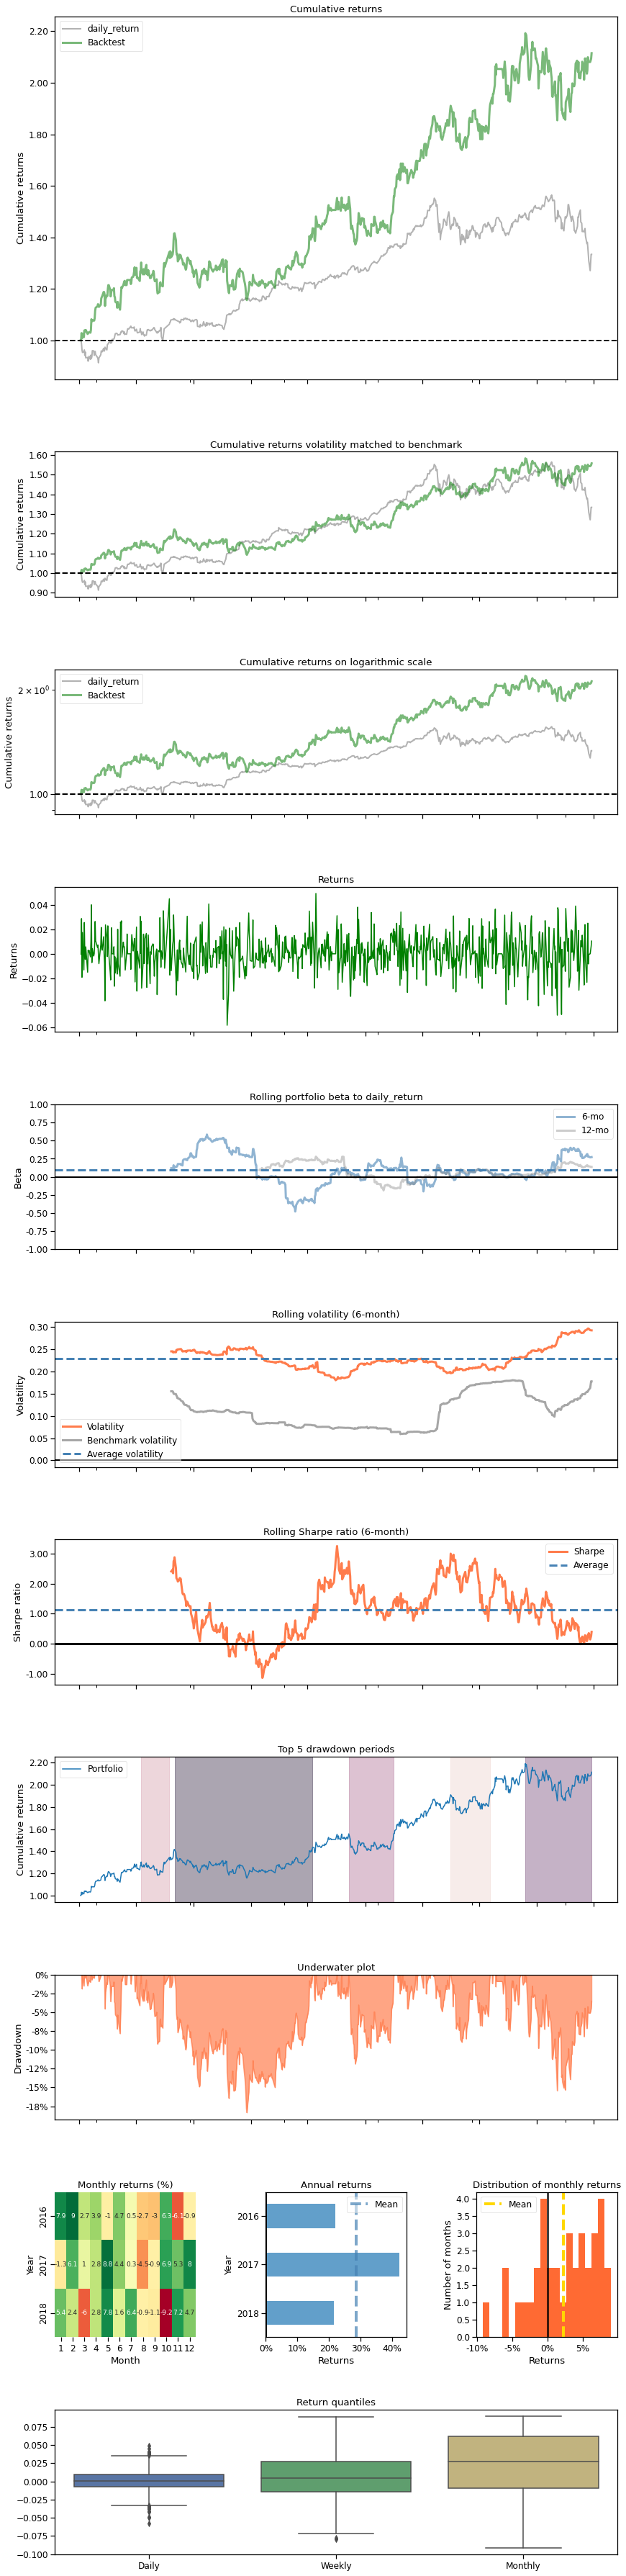

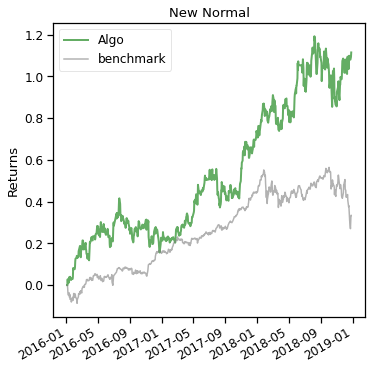

In [63]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_a2c, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value_a2c.loc[0,'date'],
             baseline_end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])